In [16]:
import sklearn
print(sklearn.__version__)
import scipy
print(scipy.__version__)
import numpy
print(numpy.__version__)
import matplotlib
print(matplotlib.__version__)
import tqdm
print(tqdm.__version__)

0.24.2
1.7.1
1.20.3
3.4.3
4.62.3


In [15]:
pip install --upgrade torch torchvision

Note: you may need to restart the kernel to use updated packages.


In [20]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())
import torchvision
print(torchvision.__version__)


2.0.1+cpu
False
0.15.2+cpu


In [21]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import random
from PIL import Image

from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Compose, Resize, CenterCrop
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from tqdm import tqdm  # Import tqdm for progress bar



In [22]:
## config.py Code

'''This file configures the training procedure because handling arguments in every single function is so exhaustive for
research purposes. Don't try this code if you are a software engineer.'''

# device settings
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(0) if device.type == 'cuda' else None

# data settings
dataset_path = "dummy_dataset"
class_name = "dummy_class"
modelname = "marble_test"

img_size = (448, 448)
img_dims = [3] + list(img_size)

# transformation settings
transf_rotations = True
transf_brightness = 0.0
transf_contrast = 0.0
transf_saturation = 0.0
norm_mean, norm_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

# network hyperparameters
n_scales = 3 # number of scales at which features are extracted, img_size is the highest - others are //2, //4,...
clamp_alpha = 3 # see paper equation 2 for explanation
n_coupling_blocks = 8
fc_internal = 2048 # number of neurons in hidden layers of s-t-networks
dropout = 0.0 # dropout in s-t-networks
lr_init = 2e-4
n_feat = 256 * n_scales # do not change except you change the feature extractor

# dataloader parameters
n_transforms = 4 # number of transformations per sample in training
n_transforms_test = 64 # number of transformations per sample in testing
batch_size = 24 # actual batch size is this value multiplied by n_transforms(_test)
batch_size_test = batch_size * n_transforms // n_transforms_test

# total epochs = meta_epochs * sub_epochs
# evaluation after <sub_epochs> epochs
meta_epochs = 24
sub_epochs = 8

# output settings
verbose = True
grad_map_viz = False
hide_tqdm_bar = True
save_model = True


In [23]:
## utils.py

import os
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms.functional import rotate
from multi_transform_loader import ImageFolderMultiTransform

# Set the device here
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def get_random_transforms(transf_rotations, transf_brightness, transf_contrast, transf_saturation, img_size, norm_mean, norm_std):
    augmentative_transforms = []
    if transf_rotations:
        augmentative_transforms += [transforms.RandomRotation(180)]
    if transf_brightness > 0.0 or transf_contrast > 0.0 or transf_saturation > 0.0:
        augmentative_transforms += [transforms.ColorJitter(brightness=transf_brightness, contrast=transf_contrast,
                                                           saturation=transf_saturation)]

    tfs = [transforms.Resize(img_size)] + augmentative_transforms + [transforms.ToTensor(),
                                                                       transforms.Normalize(norm_mean, norm_std)]

    transform_train = transforms.Compose(tfs)
    return transform_train

def get_fixed_transforms(degrees, transf_brightness, transf_contrast, transf_saturation, img_size, norm_mean, norm_std):
    cust_rot = lambda x: rotate(x, degrees, False, False, None)
    augmentative_transforms = [cust_rot]
    if transf_brightness > 0.0 or transf_contrast > 0.0 or transf_saturation > 0.0:
        augmentative_transforms += [
            transforms.ColorJitter(brightness=transf_brightness, contrast=transf_contrast,
                                   saturation=transf_saturation)]
    tfs = [transforms.Resize(img_size)] + augmentative_transforms + [transforms.ToTensor(),
                                                                       transforms.Normalize(norm_mean,
                                                                                            norm_std)]
    return transforms.Compose(tfs)

def t2np(tensor):
    '''pytorch tensor -> numpy array'''
    return tensor.cpu().data.numpy() if tensor is not None else None

# Rest of the code remains unchanged...


def get_loss(z, jac):
    '''check equation 4 of the paper why this makes sense - oh and just ignore the scaling here'''
    return torch.mean(0.5 * torch.sum(z ** 2, dim=(1,)) - jac) / z.shape[1]


def load_datasets(dataset_path, class_name):
    '''
    Expected folder/file format to find anomalies of class <class_name> from dataset location <dataset_path>:

    train data:

            dataset_path/class_name/train/good/any_filename.png
            dataset_path/class_name/train/good/another_filename.tif
            dataset_path/class_name/train/good/xyz.png
            [...]

    test data:

        'normal data' = non-anomalies

            dataset_path/class_name/test/good/name_the_file_as_you_like_as_long_as_there_is_an_image_extension.webp
            dataset_path/class_name/test/good/did_you_know_the_image_extension_webp?.png
            dataset_path/class_name/test/good/did_you_know_that_filenames_may_contain_question_marks????.png
            dataset_path/class_name/test/good/dont_know_how_it_is_with_windows.png
            dataset_path/class_name/test/good/just_dont_use_windows_for_this.png
            [...]

        anomalies - assume there are anomaly classes 'crack' and 'curved'

            dataset_path/class_name/test/crack/dat_crack_damn.png
            dataset_path/class_name/test/crack/let_it_crack.png
            dataset_path/class_name/test/crack/writing_docs_is_fun.png
            [...]

            dataset_path/class_name/test/curved/wont_make_a_difference_if_you_put_all_anomalies_in_one_class.png
            dataset_path/class_name/test/curved/but_this_code_is_practicable_for_the_mvtec_dataset.png
            [...]
    '''

    def target_transform(target):
        return class_perm[target]

    data_dir_train = os.path.join(dataset_path, class_name, 'train')
    data_dir_test = os.path.join(dataset_path, class_name, 'test')

    classes = os.listdir(data_dir_test)
    if 'good' not in classes:
        print('There should exist a subdirectory "good". Read the doc of this function for further information.')
        exit()
    classes.sort()
    class_perm = list()
    class_idx = 1
    for cl in classes:
        if cl == 'good':
            class_perm.append(0)
        else:
            class_perm.append(class_idx)
            class_idx += 1

    transform_train = get_random_transforms()

    trainset = ImageFolderMultiTransform(data_dir_train, transform=transform_train, n_transforms=c.n_transforms)
    testset = ImageFolderMultiTransform(data_dir_test, transform=transform_train, target_transform=target_transform,
                                        n_transforms=c.n_transforms_test)
    return trainset, testset


def make_dataloaders(trainset, testset):
    trainloader = torch.utils.data.DataLoader(trainset, pin_memory=True, batch_size=c.batch_size, shuffle=True,
                                              drop_last=False)
    testloader = torch.utils.data.DataLoader(testset, pin_memory=True, batch_size=c.batch_size_test, shuffle=True,
                                             drop_last=False)
    return trainloader, testloader


def preprocess_batch(data):
    '''move data to device and reshape image'''
    inputs, labels = data
    inputs, labels = inputs.to(c.device), labels.to(c.device)
    inputs = inputs.view(-1, *inputs.shape[-3:])
    return inputs, labels




In [24]:
## train.py Code

import numpy as np
import torch
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

import config as c
from localization import export_gradient_maps
from model import DifferNet, save_model, save_weights
from utils import *


class Score_Observer:
    '''Keeps an eye on the current and highest score so far'''

    def __init__(self, name):
        self.name = name
        self.max_epoch = 0
        self.max_score = None
        self.last = None

    def update(self, score, epoch, print_score=False):
        self.last = score
        if epoch == 0 or score > self.max_score:
            self.max_score = score
            self.max_epoch = epoch
        if print_score:
            self.print_score()

    def print_score(self):
        print('{:s}: \t last: {:.4f} \t max: {:.4f} \t epoch_max: {:d}'.format(self.name, self.last, self.max_score,
                                                                               self.max_epoch))


def train(train_loader, test_loader):
    model = DifferNet()
    optimizer = torch.optim.Adam(model.nf.parameters(), lr=c.lr_init, betas=(0.8, 0.8), eps=1e-04, weight_decay=1e-5)
    model.to(c.device)

    score_obs = Score_Observer('AUROC')

    for epoch in range(c.meta_epochs):

        # train some epochs
        model.train()
        if c.verbose:
            print(F'\nTrain epoch {epoch}')
        for sub_epoch in range(c.sub_epochs):
            train_loss = list()
            for i, data in enumerate(tqdm(train_loader, disable=c.hide_tqdm_bar)):
                optimizer.zero_grad()
                inputs, labels = preprocess_batch(data)  # move to device and reshape
                # TODO inspect
                # inputs += torch.randn(*inputs.shape).cuda() * c.add_img_noise

                z = model(inputs)
                loss = get_loss(z, model.nf.jacobian(run_forward=False))
                train_loss.append(t2np(loss))
                loss.backward()
                optimizer.step()

            mean_train_loss = np.mean(train_loss)
            if c.verbose:
                print('Epoch: {:d}.{:d} \t train loss: {:.4f}'.format(epoch, sub_epoch, mean_train_loss))

        # evaluate
        model.eval()
        if c.verbose:
            print('\nCompute loss and scores on test set:')
        test_loss = list()
        test_z = list()
        test_labels = list()
        with torch.no_grad():
            for i, data in enumerate(tqdm(test_loader, disable=c.hide_tqdm_bar)):
                inputs, labels = preprocess_batch(data)
                z = model(inputs)
                loss = get_loss(z, model.nf.jacobian(run_forward=False))
                test_z.append(z)
                test_loss.append(t2np(loss))
                test_labels.append(t2np(labels))

        test_loss = np.mean(np.array(test_loss))
        if c.verbose:
            print('Epoch: {:d} \t test_loss: {:.4f}'.format(epoch, test_loss))

        test_labels = np.concatenate(test_labels)
        is_anomaly = np.array([0 if l == 0 else 1 for l in test_labels])

        z_grouped = torch.cat(test_z, dim=0).view(-1, c.n_transforms_test, c.n_feat)
        anomaly_score = t2np(torch.mean(z_grouped ** 2, dim=(-2, -1)))
        score_obs.update(roc_auc_score(is_anomaly, anomaly_score), epoch,
                         print_score=c.verbose or epoch == c.meta_epochs - 1)

    if c.grad_map_viz:
        export_gradient_maps(model, test_loader, optimizer, -1)

    if c.save_model:
        model.to('cpu')
        save_model(model, c.modelname)
        save_weights(model, c.modelname)
    return model


In [8]:
## main.py Code

import config as c
from train import train
from utils import load_datasets, make_dataloaders, get_random_transforms
import torch
from tqdm import tqdm

def train_with_progress(train_loader, test_loader):
    model = train(train_loader, test_loader)
    return model

if __name__ == "__main__":
    train_set, test_set = load_datasets(c.dataset_path, c.class_name)
    train_loader, test_loader = make_dataloaders(train_set, test_set)

    # Wrap the training process with tqdm
    with tqdm(total=len(train_loader), desc="Training", unit="batch") as pbar:
        model = train_with_progress(train_loader, test_loader)
        pbar.update()


Training:   0%|          | 0/4 [00:00<?, ?batch/s]C:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Train epoch 0
Epoch: 0.0 	 train loss: 0.2835
Epoch: 0.1 	 train loss: -0.0631
Epoch: 0.2 	 train loss: -0.3913
Epoch: 0.3 	 train loss: -0.7611
Epoch: 0.4 	 train loss: -0.8662
Epoch: 0.5 	 train loss: -1.0767
Epoch: 0.6 	 train loss: -1.1873
Epoch: 0.7 	 train loss: -1.2719

Compute loss and scores on test set:
Epoch: 0 	 test_loss: 1018786.1250
AUROC: 	 last: 0.6908 	 max: 0.6908 	 epoch_max: 0

Train epoch 1
Epoch: 1.0 	 train loss: -1.3183
Epoch: 1.1 	 train loss: -1.4189
Epoch: 1.2 	 train loss: -1.4861
Epoch: 1.3 	 train loss: -1.5430
Epoch: 1.4 	 train loss: -1.5303
Epoch: 1.5 	 train loss: -1.5360
Epoch: 1.6 	 train loss: -1.5704
Epoch: 1.7 	 train loss: -1.6334

Compute loss and scores on test set:
Epoch: 1 	 test_loss: 28132442.0000
AUROC: 	 last: 0.7600 	 max: 0.7600 	 epoch_max: 1

Train epoch 2
Epoch: 2.0 	 train loss: -1.6971
Epoch: 2.1 	 train loss: -1.7156
Epoch: 2.2 	 train loss: -1.6621
Epoch: 2.3 	 train loss: -1.7772
Epoch: 2.4 	 train loss: -1.8332
Epoch: 2.5 	 t

Epoch: 20.0 	 train loss: -2.7056
Epoch: 20.1 	 train loss: -2.7054
Epoch: 20.2 	 train loss: -2.7164
Epoch: 20.3 	 train loss: -2.6825
Epoch: 20.4 	 train loss: -2.6855
Epoch: 20.5 	 train loss: -2.7109
Epoch: 20.6 	 train loss: -2.6944
Epoch: 20.7 	 train loss: -2.7033

Compute loss and scores on test set:
Epoch: 20 	 test_loss: 3735180032.0000
AUROC: 	 last: 0.7992 	 max: 0.8733 	 epoch_max: 9

Train epoch 21
Epoch: 21.0 	 train loss: -2.7245
Epoch: 21.1 	 train loss: -2.7247
Epoch: 21.2 	 train loss: -2.7100
Epoch: 21.3 	 train loss: -2.7445
Epoch: 21.4 	 train loss: -2.7490
Epoch: 21.5 	 train loss: -2.7210
Epoch: 21.6 	 train loss: -2.7309
Epoch: 21.7 	 train loss: -2.7561

Compute loss and scores on test set:
Epoch: 21 	 test_loss: 3748888064.0000
AUROC: 	 last: 0.8467 	 max: 0.8733 	 epoch_max: 9

Train epoch 22
Epoch: 22.0 	 train loss: -2.7819
Epoch: 22.1 	 train loss: -2.7152
Epoch: 22.2 	 train loss: -2.7361
Epoch: 22.3 	 train loss: -2.7581
Epoch: 22.4 	 train loss: -2.771

Training:  25%|██▌       | 1/4 [27:04:49<81:14:29, 97489.89s/batch]


image: dummy_dataset/dummy_class/train/good\_0_0_20210525_15395.jpg, score: 1.26
image: dummy_dataset/dummy_class/train/good\_0_0_20210525_154.jpg, score: 1.22
image: dummy_dataset/dummy_class/train/good\_0_0_20210525_15441.jpg, score: 1.19
image: dummy_dataset/dummy_class/train/good\_0_0_20210531_10540.jpg, score: 1.22
image: dummy_dataset/dummy_class/train/good\_0_0_20210531_10553.jpg, score: 1.23
image: dummy_dataset/dummy_class/train/good\_0_0_20210531_11192.jpg, score: 1.19
image: dummy_dataset/dummy_class/train/good\_0_0_20210531_11194.jpg, score: 1.20
image: dummy_dataset/dummy_class/train/good\_0_0_20210531_11274.jpg, score: 1.14
image: dummy_dataset/dummy_class/train/good\_0_0_65.jpg, score: 1.15
image: dummy_dataset/dummy_class/train/good\_0_256_20210525_15395.jpg, score: 1.33
image: dummy_dataset/dummy_class/train/good\_0_256_20210525_154.jpg, score: 1.22
image: dummy_dataset/dummy_class/train/good\_0_512_20210531_11274.jpg, score: 1.28
image: dummy_dataset/dummy_class/train

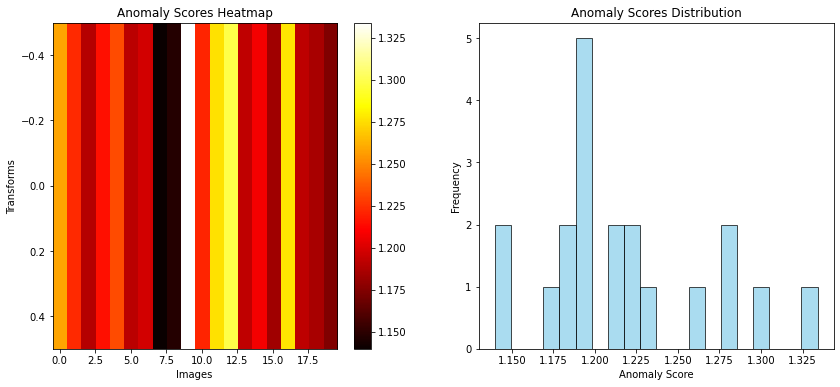

In [12]:
# From Train Folder > Good Folder Images

from model import load_model
from os import listdir
from os.path import join
from utils import get_random_transforms, get_fixed_transforms
from PIL import Image
import config as c
import torch
import matplotlib.pyplot as plt
import numpy as np

def evaluate_with_heatmap_and_histogram(model_name, image_folder, fixed_transforms=True):
    model = load_model(model_name)
    files = listdir(image_folder)

    if fixed_transforms:
        fixed_degrees = [i * 360.0 / c.n_transforms_test for i in range(c.n_transforms_test)]
        transforms = [get_fixed_transforms(fd) for fd in fixed_degrees]
    else:
        transforms = [get_random_transforms()] * c.n_transforms_test

    anomaly_scores = []

    for f in files:
        anomaly_score = get_anomaly_score(model, join(image_folder, f), transforms)
        anomaly_scores.append(anomaly_score.item())  # Convert to scalar and store

    # Create a heatmap
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    ax1.set_title("Anomaly Scores Heatmap")
    ax1.set_xlabel("Images")
    ax1.set_ylabel("Transforms")

    cmap = plt.get_cmap('hot')  
    im = ax1.imshow([anomaly_scores], cmap=cmap, aspect='auto', interpolation='none')
    fig.colorbar(im, ax=ax1)

    # Create a histogram
    ax2.hist(anomaly_scores, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
    ax2.set_title("Anomaly Scores Distribution")
    ax2.set_xlabel("Anomaly Score")
    ax2.set_ylabel("Frequency")

    # Show the plots
    plt.show()

image_folder = 'dummy_dataset/dummy_class/train/good'
evaluate_with_heatmap_and_histogram(c.modelname, image_folder, fixed_transforms=True)

image: dummy_dataset/dummy_class/train/crack\_0_0_20210531_17292.jpg, score: 1.16
image: dummy_dataset/dummy_class/train/crack\_0_0_20210531_17292_1.jpg, score: 1.17
image: dummy_dataset/dummy_class/train/crack\_0_0_20210531_17292_2.jpg, score: 1.08
image: dummy_dataset/dummy_class/train/crack\_0_0_20210531_17292_3.jpg, score: 1.16
image: dummy_dataset/dummy_class/train/crack\_0_0_20210531_17293.jpg, score: 1.19
image: dummy_dataset/dummy_class/train/crack\_0_0_20210531_17293_2.jpg, score: 1.10
image: dummy_dataset/dummy_class/train/crack\_0_0_20210531_17293_3.jpg, score: 1.14
image: dummy_dataset/dummy_class/train/crack\_0_1280_20210525_14425_1.jpg, score: 1.24
image: dummy_dataset/dummy_class/train/crack\_0_1280_20210525_14425_2.jpg, score: 1.20
image: dummy_dataset/dummy_class/train/crack\_0_1280_20210525_14425_3.jpg, score: 1.27
image: dummy_dataset/dummy_class/train/crack\_0_1280_20210525_14462.jpg, score: 1.22
image: dummy_dataset/dummy_class/train/crack\_0_1280_20210525_14462_1.

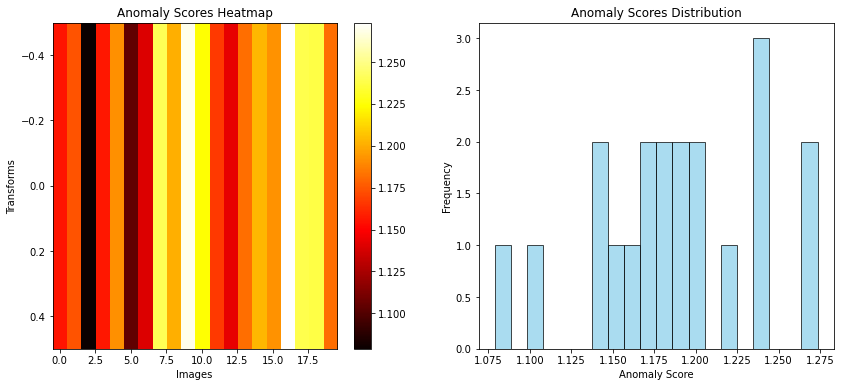

In [14]:
# From Train Folder > crack Folder Images

from model import load_model
from os import listdir
from os.path import join
from utils import get_random_transforms, get_fixed_transforms
from PIL import Image
import config as c
import torch
import matplotlib.pyplot as plt
import numpy as np

def evaluate_with_heatmap_and_histogram(model_name, image_folder, fixed_transforms=True):
    model = load_model(model_name)
    files = listdir(image_folder)

    if fixed_transforms:
        fixed_degrees = [i * 360.0 / c.n_transforms_test for i in range(c.n_transforms_test)]
        transforms = [get_fixed_transforms(fd) for fd in fixed_degrees]
    else:
        transforms = [get_random_transforms()] * c.n_transforms_test

    anomaly_scores = []

    for f in files:
        anomaly_score = get_anomaly_score(model, join(image_folder, f), transforms)
        anomaly_scores.append(anomaly_score.item())  # Convert to scalar and store

    # Create a heatmap
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    ax1.set_title("Anomaly Scores Heatmap")
    ax1.set_xlabel("Images")
    ax1.set_ylabel("Transforms")

    cmap = plt.get_cmap('hot')  
    im = ax1.imshow([anomaly_scores], cmap=cmap, aspect='auto', interpolation='none')
    fig.colorbar(im, ax=ax1)

    # Create a histogram
    ax2.hist(anomaly_scores, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
    ax2.set_title("Anomaly Scores Distribution")
    ax2.set_xlabel("Anomaly Score")
    ax2.set_ylabel("Frequency")

    # Show the plots
    plt.show()

image_folder = 'dummy_dataset/dummy_class/train/crack'
evaluate_with_heatmap_and_histogram(c.modelname, image_folder, fixed_transforms=True)

image: dummy_dataset/dummy_class/train/dot\_0_0_20210525_14462.jpg, score: 1.21
image: dummy_dataset/dummy_class/train/dot\_0_0_20210525_14462_0.jpg, score: 1.19
image: dummy_dataset/dummy_class/train/dot\_0_0_20210525_14462_1.jpg, score: 1.18
image: dummy_dataset/dummy_class/train/dot\_0_0_20210525_14462_2.jpg, score: 1.23
image: dummy_dataset/dummy_class/train/dot\_0_2560_20210531_10521.jpg, score: 1.20
image: dummy_dataset/dummy_class/train/dot\_0_2560_20210531_10521_0.jpg, score: 1.19
image: dummy_dataset/dummy_class/train/dot\_0_2560_20210531_10521_1.jpg, score: 1.22
image: dummy_dataset/dummy_class/train/dot\_0_2816_20210525_14432.jpg, score: 1.22
image: dummy_dataset/dummy_class/train/dot\_0_2816_20210525_14432_0.jpg, score: 1.25
image: dummy_dataset/dummy_class/train/dot\_0_2816_20210525_14432_1.jpg, score: 1.25
image: dummy_dataset/dummy_class/train/dot\_0_2816_20210525_14432_2.jpg, score: 1.19
image: dummy_dataset/dummy_class/train/dot\_0_3328_20210525_14432.jpg, score: 1.23


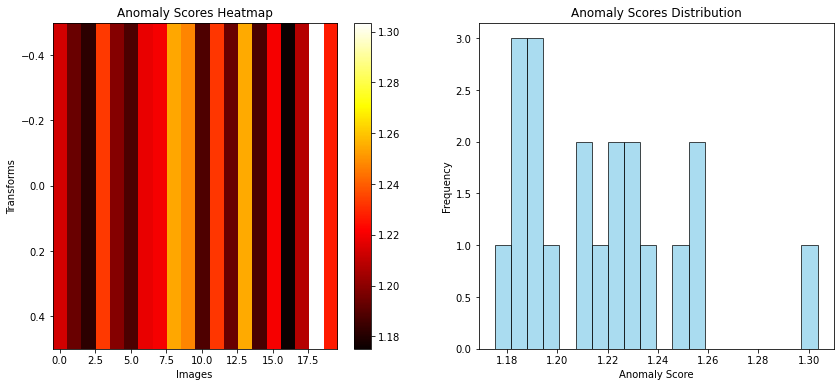

In [15]:
# From Train Folder > dot Folder Images

from model import load_model
from os import listdir
from os.path import join
from utils import get_random_transforms, get_fixed_transforms
from PIL import Image
import config as c
import torch
import matplotlib.pyplot as plt
import numpy as np

def evaluate_with_heatmap_and_histogram(model_name, image_folder, fixed_transforms=True):
    model = load_model(model_name)
    files = listdir(image_folder)

    if fixed_transforms:
        fixed_degrees = [i * 360.0 / c.n_transforms_test for i in range(c.n_transforms_test)]
        transforms = [get_fixed_transforms(fd) for fd in fixed_degrees]
    else:
        transforms = [get_random_transforms()] * c.n_transforms_test

    anomaly_scores = []

    for f in files:
        anomaly_score = get_anomaly_score(model, join(image_folder, f), transforms)
        anomaly_scores.append(anomaly_score.item())  # Convert to scalar and store

    # Create a heatmap
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    ax1.set_title("Anomaly Scores Heatmap")
    ax1.set_xlabel("Images")
    ax1.set_ylabel("Transforms")

    cmap = plt.get_cmap('hot')  
    im = ax1.imshow([anomaly_scores], cmap=cmap, aspect='auto', interpolation='none')
    fig.colorbar(im, ax=ax1)

    # Create a histogram
    ax2.hist(anomaly_scores, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
    ax2.set_title("Anomaly Scores Distribution")
    ax2.set_xlabel("Anomaly Score")
    ax2.set_ylabel("Frequency")

    # Show the plots
    plt.show()

image_folder = 'dummy_dataset/dummy_class/train/dot'
evaluate_with_heatmap_and_histogram(c.modelname, image_folder, fixed_transforms=True)

image: dummy_dataset/dummy_class/train/joint\_0_2304_20210531_10551.jpg, score: 1.27
image: dummy_dataset/dummy_class/train/joint\_0_2304_20210531_10551_0.jpg, score: 1.24
image: dummy_dataset/dummy_class/train/joint\_0_2304_20210531_10551_1.jpg, score: 1.30
image: dummy_dataset/dummy_class/train/joint\_0_2304_20210531_10551_2.jpg, score: 1.26
image: dummy_dataset/dummy_class/train/joint\_0_256_20210525_14425.jpg, score: 1.26
image: dummy_dataset/dummy_class/train/joint\_0_256_20210525_14425_0.jpg, score: 1.26
image: dummy_dataset/dummy_class/train/joint\_0_256_20210525_14425_1.jpg, score: 1.25
image: dummy_dataset/dummy_class/train/joint\_0_256_20210525_14425_2.jpg, score: 1.26
image: dummy_dataset/dummy_class/train/joint\_0_3584_20210531_11274.jpg, score: 1.24
image: dummy_dataset/dummy_class/train/joint\_0_3584_20210531_11274_0.jpg, score: 1.30
image: dummy_dataset/dummy_class/train/joint\_0_3584_20210531_11274_1.jpg, score: 1.23
image: dummy_dataset/dummy_class/train/joint\_0_3584_

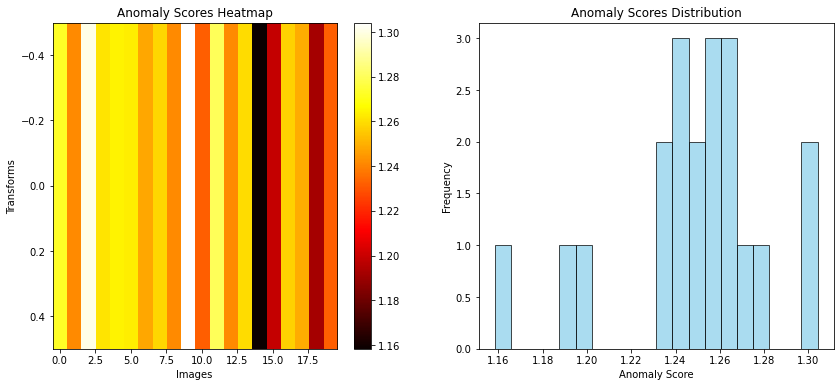

In [16]:
# From Train Folder > joint Folder Images

from model import load_model
from os import listdir
from os.path import join
from utils import get_random_transforms, get_fixed_transforms
from PIL import Image
import config as c
import torch
import matplotlib.pyplot as plt
import numpy as np

def evaluate_with_heatmap_and_histogram(model_name, image_folder, fixed_transforms=True):
    model = load_model(model_name)
    files = listdir(image_folder)

    if fixed_transforms:
        fixed_degrees = [i * 360.0 / c.n_transforms_test for i in range(c.n_transforms_test)]
        transforms = [get_fixed_transforms(fd) for fd in fixed_degrees]
    else:
        transforms = [get_random_transforms()] * c.n_transforms_test

    anomaly_scores = []

    for f in files:
        anomaly_score = get_anomaly_score(model, join(image_folder, f), transforms)
        anomaly_scores.append(anomaly_score.item())  # Convert to scalar and store

    # Create a heatmap
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    ax1.set_title("Anomaly Scores Heatmap")
    ax1.set_xlabel("Images")
    ax1.set_ylabel("Transforms")

    cmap = plt.get_cmap('hot')  
    im = ax1.imshow([anomaly_scores], cmap=cmap, aspect='auto', interpolation='none')
    fig.colorbar(im, ax=ax1)

    # Create a histogram
    ax2.hist(anomaly_scores, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
    ax2.set_title("Anomaly Scores Distribution")
    ax2.set_xlabel("Anomaly Score")
    ax2.set_ylabel("Frequency")

    # Show the plots
    plt.show()

image_folder = 'dummy_dataset/dummy_class/train/joint'
evaluate_with_heatmap_and_histogram(c.modelname, image_folder, fixed_transforms=True)

image: dummy_dataset/dummy_class/test/crack\_0_0_20210531_17292_0.jpg, score: 1.08
image: dummy_dataset/dummy_class/test/crack\_0_0_20210531_17293_0.jpg, score: 2.02
image: dummy_dataset/dummy_class/test/crack\_0_0_20210531_17293_1.jpg, score: 68277.38
image: dummy_dataset/dummy_class/test/crack\_0_1280_20210525_14425.jpg, score: 1.41
image: dummy_dataset/dummy_class/test/crack\_0_1280_20210525_14425_0.jpg, score: 1.40
image: dummy_dataset/dummy_class/test/crack\_0_1280_20210525_14462_0.jpg, score: 1.24
image: dummy_dataset/dummy_class/test/crack\_0_1536_20210525_14462.jpg, score: 1.55
image: dummy_dataset/dummy_class/test/crack\_0_2304_20210525_14425_1.jpg, score: 272541368320.00
image: dummy_dataset/dummy_class/test/crack\_0_2560_20210525_13375_0.jpg, score: 2.22
image: dummy_dataset/dummy_class/test/crack\_0_2560_20210525_14425_0.jpg, score: 388774199296.00
image: dummy_dataset/dummy_class/test/crack\_0_3072_20210525_15144_2.jpg, score: 4.87
image: dummy_dataset/dummy_class/test/cra

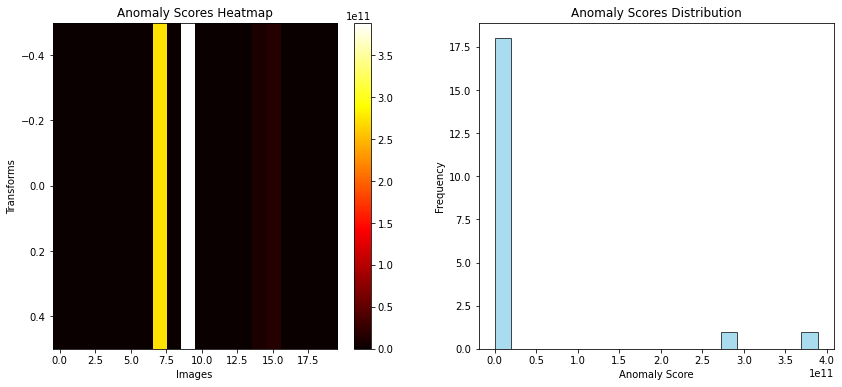

In [17]:
# From Test Folder > crack Folder Images

from model import load_model
from os import listdir
from os.path import join
from utils import get_random_transforms, get_fixed_transforms
from PIL import Image
import config as c
import torch
import matplotlib.pyplot as plt
import numpy as np

def evaluate_with_heatmap_and_histogram(model_name, image_folder, fixed_transforms=True):
    model = load_model(model_name)
    files = listdir(image_folder)

    if fixed_transforms:
        fixed_degrees = [i * 360.0 / c.n_transforms_test for i in range(c.n_transforms_test)]
        transforms = [get_fixed_transforms(fd) for fd in fixed_degrees]
    else:
        transforms = [get_random_transforms()] * c.n_transforms_test

    anomaly_scores = []

    for f in files:
        anomaly_score = get_anomaly_score(model, join(image_folder, f), transforms)
        anomaly_scores.append(anomaly_score.item())  # Convert to scalar and store

    # Create a heatmap
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    ax1.set_title("Anomaly Scores Heatmap")
    ax1.set_xlabel("Images")
    ax1.set_ylabel("Transforms")

    cmap = plt.get_cmap('hot')  
    im = ax1.imshow([anomaly_scores], cmap=cmap, aspect='auto', interpolation='none')
    fig.colorbar(im, ax=ax1)

    # Create a histogram
    ax2.hist(anomaly_scores, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
    ax2.set_title("Anomaly Scores Distribution")
    ax2.set_xlabel("Anomaly Score")
    ax2.set_ylabel("Frequency")

    # Show the plots
    plt.show()

image_folder = 'dummy_dataset/dummy_class/test/crack'
evaluate_with_heatmap_and_histogram(c.modelname, image_folder, fixed_transforms=True)

image: dummy_dataset/dummy_class/test/dot\_0_2560_20210531_10521_2.jpg, score: 1.62
image: dummy_dataset/dummy_class/test/dot\_0_3328_20210525_14432_0.jpg, score: 1.39
image: dummy_dataset/dummy_class/test/dot\_1280_1536_20210531_11201_0.jpg, score: 1.74
image: dummy_dataset/dummy_class/test/dot\_1280_1536_20210531_11201_1.jpg, score: 1.90
image: dummy_dataset/dummy_class/test/dot\_1280_2048_20210525_15144_2.jpg, score: 1.82
image: dummy_dataset/dummy_class/test/dot\_1536_1280_20210531_10521_0.jpg, score: 1.50
image: dummy_dataset/dummy_class/test/dot\_1536_2304_20210525_14462.jpg, score: 1.80
image: dummy_dataset/dummy_class/test/dot\_1536_2304_20210525_14462_2.jpg, score: 3.10
image: dummy_dataset/dummy_class/test/dot\_1536_4352_20210531_10521_0.jpg, score: 2.32
image: dummy_dataset/dummy_class/test/dot\_1536_4352_20210531_10521_2.jpg, score: 2.28
image: dummy_dataset/dummy_class/test/dot\_1792_1024_20210525_15175.jpg, score: 1.37
image: dummy_dataset/dummy_class/test/dot\_1792_1024_

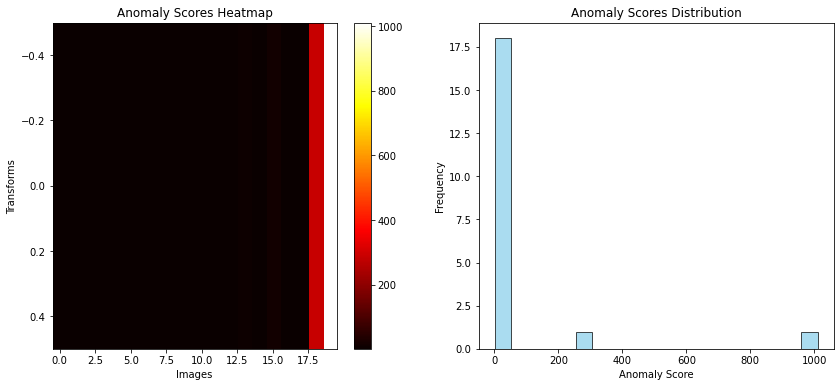

In [18]:
# From Test Folder > dot Folder Images

from model import load_model
from os import listdir
from os.path import join
from utils import get_random_transforms, get_fixed_transforms
from PIL import Image
import config as c
import torch
import matplotlib.pyplot as plt
import numpy as np

def evaluate_with_heatmap_and_histogram(model_name, image_folder, fixed_transforms=True):
    model = load_model(model_name)
    files = listdir(image_folder)

    if fixed_transforms:
        fixed_degrees = [i * 360.0 / c.n_transforms_test for i in range(c.n_transforms_test)]
        transforms = [get_fixed_transforms(fd) for fd in fixed_degrees]
    else:
        transforms = [get_random_transforms()] * c.n_transforms_test

    anomaly_scores = []

    for f in files:
        anomaly_score = get_anomaly_score(model, join(image_folder, f), transforms)
        anomaly_scores.append(anomaly_score.item())  # Convert to scalar and store

    # Create a heatmap
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    ax1.set_title("Anomaly Scores Heatmap")
    ax1.set_xlabel("Images")
    ax1.set_ylabel("Transforms")

    cmap = plt.get_cmap('hot')  
    im = ax1.imshow([anomaly_scores], cmap=cmap, aspect='auto', interpolation='none')
    fig.colorbar(im, ax=ax1)

    # Create a histogram
    ax2.hist(anomaly_scores, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
    ax2.set_title("Anomaly Scores Distribution")
    ax2.set_xlabel("Anomaly Score")
    ax2.set_ylabel("Frequency")

    # Show the plots
    plt.show()

image_folder = 'dummy_dataset/dummy_class/test/dot'
evaluate_with_heatmap_and_histogram(c.modelname, image_folder, fixed_transforms=True)

image: dummy_dataset/dummy_class/test/good\_0_0_20210525_15434.jpg, score: 1.57
image: dummy_dataset/dummy_class/test/good\_0_0_20210531_10545.jpg, score: 1.21
image: dummy_dataset/dummy_class/test/good\_0_0_20210531_10551.jpg, score: 1.60
image: dummy_dataset/dummy_class/test/good\_0_0_20210531_10552.jpg, score: 1.46
image: dummy_dataset/dummy_class/test/good\_0_0_20210531_111.jpg, score: 1.19
image: dummy_dataset/dummy_class/test/good\_0_0_20210531_11254.jpg, score: 1.41
image: dummy_dataset/dummy_class/test/good\_0_1024_20210525_15395.jpg, score: 1.66
image: dummy_dataset/dummy_class/test/good\_0_1024_20210525_15441.jpg, score: 1.57
image: dummy_dataset/dummy_class/test/good\_0_1024_20210531_10540.jpg, score: 1.24
image: dummy_dataset/dummy_class/test/good\_0_256_20210525_15434.jpg, score: 1.64
image: dummy_dataset/dummy_class/test/good\_0_256_20210531_10553.jpg, score: 1.26
image: dummy_dataset/dummy_class/test/good\_0_256_20210531_11254.jpg, score: 1.21
image: dummy_dataset/dummy_

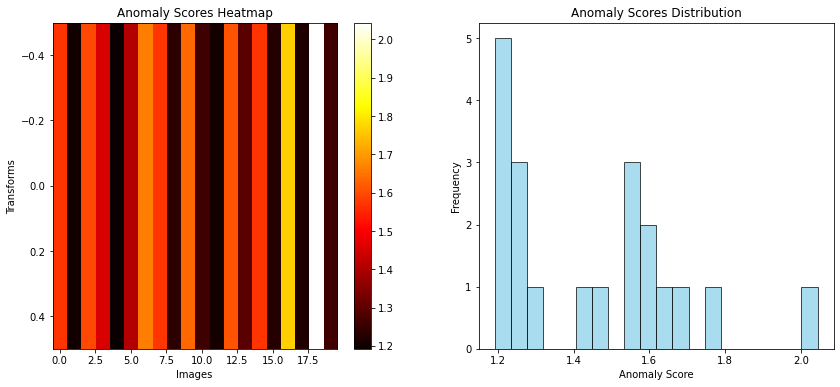

In [19]:
# From Test Folder > good Folder Images

from model import load_model
from os import listdir
from os.path import join
from utils import get_random_transforms, get_fixed_transforms
from PIL import Image
import config as c
import torch
import matplotlib.pyplot as plt
import numpy as np

def evaluate_with_heatmap_and_histogram(model_name, image_folder, fixed_transforms=True):
    model = load_model(model_name)
    files = listdir(image_folder)

    if fixed_transforms:
        fixed_degrees = [i * 360.0 / c.n_transforms_test for i in range(c.n_transforms_test)]
        transforms = [get_fixed_transforms(fd) for fd in fixed_degrees]
    else:
        transforms = [get_random_transforms()] * c.n_transforms_test

    anomaly_scores = []

    for f in files:
        anomaly_score = get_anomaly_score(model, join(image_folder, f), transforms)
        anomaly_scores.append(anomaly_score.item())  # Convert to scalar and store

    # Create a heatmap
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    ax1.set_title("Anomaly Scores Heatmap")
    ax1.set_xlabel("Images")
    ax1.set_ylabel("Transforms")

    cmap = plt.get_cmap('hot')  
    im = ax1.imshow([anomaly_scores], cmap=cmap, aspect='auto', interpolation='none')
    fig.colorbar(im, ax=ax1)

    # Create a histogram
    ax2.hist(anomaly_scores, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
    ax2.set_title("Anomaly Scores Distribution")
    ax2.set_xlabel("Anomaly Score")
    ax2.set_ylabel("Frequency")

    # Show the plots
    plt.show()

image_folder = 'dummy_dataset/dummy_class/test/good'
evaluate_with_heatmap_and_histogram(c.modelname, image_folder, fixed_transforms=True)

image: dummy_dataset/dummy_class/test/joint\_0_4352_20210525_15441_1.jpg, score: 4.01
image: dummy_dataset/dummy_class/test/joint\_256_3584_20210531_11274_2.jpg, score: 1.98
image: dummy_dataset/dummy_class/test/joint\_256_3840_20210531_11274_0.jpg, score: 2.79
image: dummy_dataset/dummy_class/test/joint\_512_0_20210525_13375.jpg, score: 1.45
image: dummy_dataset/dummy_class/test/joint\_512_1024_20210525_13375.jpg, score: 1.52
image: dummy_dataset/dummy_class/test/joint\_512_1024_20210525_13375_1.jpg, score: 2.02
image: dummy_dataset/dummy_class/test/joint\_512_1280_20210525_13375.jpg, score: 1.47
image: dummy_dataset/dummy_class/test/joint\_512_1536_20210525_13375_2.jpg, score: 4.43
image: dummy_dataset/dummy_class/test/joint\_512_1792_20210525_13375.jpg, score: 1.63
image: dummy_dataset/dummy_class/test/joint\_512_1792_20210525_13375_0.jpg, score: 2.51
image: dummy_dataset/dummy_class/test/joint\_512_2304_20210525_13375_0.jpg, score: 8.01
image: dummy_dataset/dummy_class/test/joint\_

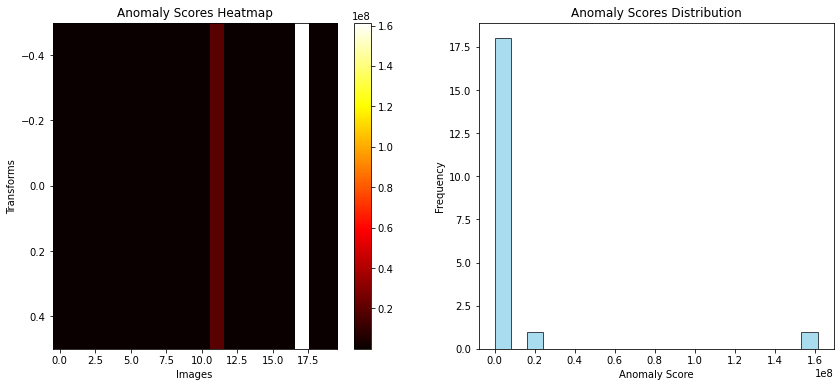

In [20]:
# From Test Folder > joint Folder Images

from model import load_model
from os import listdir
from os.path import join
from utils import get_random_transforms, get_fixed_transforms
from PIL import Image
import config as c
import torch
import matplotlib.pyplot as plt
import numpy as np

def evaluate_with_heatmap_and_histogram(model_name, image_folder, fixed_transforms=True):
    model = load_model(model_name)
    files = listdir(image_folder)

    if fixed_transforms:
        fixed_degrees = [i * 360.0 / c.n_transforms_test for i in range(c.n_transforms_test)]
        transforms = [get_fixed_transforms(fd) for fd in fixed_degrees]
    else:
        transforms = [get_random_transforms()] * c.n_transforms_test

    anomaly_scores = []

    for f in files:
        anomaly_score = get_anomaly_score(model, join(image_folder, f), transforms)
        anomaly_scores.append(anomaly_score.item())  # Convert to scalar and store

    # Create a heatmap
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    ax1.set_title("Anomaly Scores Heatmap")
    ax1.set_xlabel("Images")
    ax1.set_ylabel("Transforms")

    cmap = plt.get_cmap('hot')  
    im = ax1.imshow([anomaly_scores], cmap=cmap, aspect='auto', interpolation='none')
    fig.colorbar(im, ax=ax1)

    # Create a histogram
    ax2.hist(anomaly_scores, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
    ax2.set_title("Anomaly Scores Distribution")
    ax2.set_xlabel("Anomaly Score")
    ax2.set_ylabel("Frequency")

    # Show the plots
    plt.show()

image_folder = 'dummy_dataset/dummy_class/test/joint'
evaluate_with_heatmap_and_histogram(c.modelname, image_folder, fixed_transforms=True)

In [18]:
# Modifications the code for all subfolders using os.walk function
import os
from model import load_model
from os import listdir
from os.path import join
from utils import get_random_transforms, get_fixed_transforms
from PIL import Image
import config as c
import torch
import matplotlib.pyplot as plt
import numpy as np

def evaluate_with_heatmap_and_histogram(model_name, base_folder, fixed_transforms=True):
    model = load_model(model_name)
    anomaly_scores_dict = {}

    for root, dirs, files in os.walk(base_folder):
        for dir_name in dirs:
            folder_path = os.path.join(root, dir_name)
            if not os.path.isdir(folder_path):
                continue

            files = os.listdir(folder_path)

            if fixed_transforms:
                fixed_degrees = [i * 360.0 / c.n_transforms_test for i in range(c.n_transforms_test)]
                transforms = [get_fixed_transforms(fd) for fd in fixed_degrees]
            else:
                transforms = [get_random_transforms()] * c.n_transforms_test

            anomaly_scores = []

            for f in files:
                if f.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp')):
                    image_path = os.path.join(folder_path, f)
                    anomaly_score = get_anomaly_score(model, image_path, transforms)
                    anomaly_scores.append(anomaly_score.item())  # Convert to scalar and store

            # Store anomaly scores for this folder
            if anomaly_scores:
                anomaly_scores_dict[folder_path] = anomaly_scores

    # Create and display heatmaps and histograms for each folder
    for folder_path, anomaly_scores in anomaly_scores_dict.items():
        # Create a heatmap
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

        ax1.set_title(f"Anomaly Scores Heatmap - {os.path.basename(folder_path)}")
        ax1.set_xlabel("Images")
        ax1.set_ylabel("Transforms")

        cmap = plt.get_cmap('hot')
        im = ax1.imshow([anomaly_scores], cmap=cmap, aspect='auto', interpolation='none')
        fig.colorbar(im, ax=ax1)

        # Create a histogram
        ax2.hist(anomaly_scores, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
        ax2.set_title(f"Anomaly Scores Distribution - {os.path.basename(folder_path)}")
        ax2.set_xlabel("Anomaly Score")
        ax2.set_ylabel("Frequency")

        # Show the plots
        plt.show()

base_folder = 'dummy_dataset/dummy_class'
evaluate_with_heatmap_and_histogram(c.modelname, base_folder, fixed_transforms=True)


NameError: name 'get_anomaly_score' is not defined

In [27]:
# From Test Folder > joint Folder Images

from model import load_model
from os import listdir
from os.path import join
from utils import get_random_transforms, get_fixed_transforms
from PIL import Image
import config as c
import torch
import matplotlib.pyplot as plt
import numpy as np

def evaluate_with_heatmap_and_histogram(model_name, image_folder, fixed_transforms=True):
    model = load_model(model_name)
    files = listdir(image_folder)

    if fixed_transforms:
        fixed_degrees = [i * 360.0 / c.n_transforms_test for i in range(c.n_transforms_test)]
        transforms = [get_fixed_transforms(fd) for fd in fixed_degrees]
    else:
        transforms = [get_random_transforms()] * c.n_transforms_test

    anomaly_scores = []

    for f in files:
        anomaly_score = get_anomaly_score(model, join(image_folder, f), transforms)
        anomaly_scores.append(anomaly_score.item())  # Convert to scalar and store

    # Create a heatmap
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    ax1.set_title("Anomaly Scores Heatmap")
    ax1.set_xlabel("Images")
    ax1.set_ylabel("Transforms")

    cmap = plt.get_cmap('hot')  
    im = ax1.imshow([anomaly_scores], cmap=cmap, aspect='auto', interpolation='none')
    fig.colorbar(im, ax=ax1)

    # Create a histogram
    ax2.hist(anomaly_scores, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
    ax2.set_title("Anomaly Scores Distribution")
    ax2.set_xlabel("Anomaly Score")
    ax2.set_ylabel("Frequency")

    # Show the plots
    plt.show()

image_folder = 'dummy_dataset/dummy_class/test/joint'
evaluate_with_heatmap_and_histogram(c.modelname, image_folder, fixed_transforms=True)

NameError: name 'get_anomaly_score' is not defined